In [2]:
import os
from matplotlib import pyplot as plt
from ms2query.utils import load_pickled_file

path_data = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/libraries_and_models/gnps_15_12_2021/"


In [3]:
training_scores, training_labels, validation_scores, validation_labels = load_pickled_file(os.path.join(path_data,
                                                                                                        "final_ms2q_training_data.pickle"))

In [4]:
training_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467600 entries, 0 to 467599
Data columns (total 5 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   precursor_mz_library_spectrum                     467600 non-null  float64
 1   precursor_mz_difference                           467600 non-null  float64
 2   s2v_score                                         467600 non-null  float64
 3   average_ms2deepscore_multiple_library_structures  467600 non-null  float64
 4   average_tanimoto_score_library_structures         467600 non-null  float64
dtypes: float64(5)
memory usage: 17.8 MB


### Check if the tanimoto score distribution is relatively equal

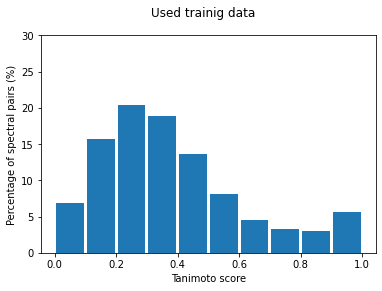

In [10]:
weight_to_convert_to_percentage = 100/len(training_labels)
weights = [weight_to_convert_to_percentage] * len(training_labels)
plt.xlabel("Tanimoto score")
plt.ylabel("Percentage of spectral pairs (%)")
plt.suptitle("Used trainig data")
plt.ylim(0, 30)

plt.hist(training_labels, weights = weights, rwidth = 0.9)
high_res_folder = "C:/Users/jonge094/OneDrive - Wageningen University & Research/PhD/Projects/MS2Query/Figures MS2Query/high_res/"
plt.savefig(os.path.join(high_res_folder, "tanimoto_score_distribution_training_data.png"), format="png", dpi=2000)
plt.show()

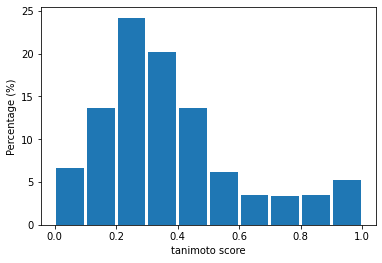

In [5]:
weight_to_convert_to_percentage = 100/len(validation_labels)
weights = [weight_to_convert_to_percentage] * len(validation_labels)
plt.xlabel("tanimoto score")
plt.ylabel("Percentage (%)")
plt.hist(validation_labels, weights = weights, rwidth = 0.9)

plt.show()

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_random_forest(selection_of_training_scores, selection_of_validation_scores, training_labels, validation_labels):
    # train rf using optimised parameters from below

    rf = RandomForestRegressor(n_estimators = 250, 
                               random_state = 42, 
                               max_depth = 5, 
                               min_samples_leaf=50,
                               n_jobs=7)
    rf.fit(selection_of_training_scores, training_labels)

    # predict on train
    rf_train_predictions = rf.predict(selection_of_training_scores)
    mse_train_rf = mean_squared_error(training_labels, rf_train_predictions)
    print('Training MSE', mse_train_rf)

    # predict on test
    rf_predictions = rf.predict(selection_of_validation_scores)
    mse_rf = mean_squared_error(validation_labels, rf_predictions)
    print('Validation MSE', mse_rf)

    # get feature importances
    importances = list(rf.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(selection_of_training_scores.columns, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    return rf

In [7]:
rf = train_random_forest(training_scores, validation_scores, training_labels, validation_labels)

C:\Users\jonge094\AppData\Local\Temp/ipykernel_4020/2986992357.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(selection_of_training_scores, training_labels)


Training MSE 0.028179792974096594
Validation MSE 0.02528175613934737
Variable: average_ms2deepscore_multiple_library_structures Importance: 0.62
Variable: precursor_mz_difference Importance: 0.18
Variable: precursor_mz_library_spectrum Importance: 0.13
Variable: s2v_score            Importance: 0.05
Variable: average_tanimoto_score_library_structures Importance: 0.02


In [8]:
import pickle
pickle.dump(rf, open(os.path.join(path_data,
                                  "ms2query_random_forest_model.pickle"), "wb"))